# Online Retail Clustering

The aim of this notebook is to use a cluster the online retail customers for targeted marketing oppurtunities.

The data consists of transactions for a UK online retail store that specialises in gifts. This notebook uses data provided on [Kaggle](https://www.kaggle.com/hellbuoy/online-retail-customer-clustering) and follows the example by [Manish Kumar.](https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering)

### Import libraries

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Load data

In [10]:
retail_full = pd.read_csv('./OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

In [11]:
retail_full.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [12]:
retail_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [17]:
retail_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [19]:
retail_full.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [52]:
# of missing values
round((retail_full.isnull().sum() / len(retail_full) * 100), 2)

InvoiceNo      0.00
StockCode      0.00
Description    0.27
Quantity       0.00
InvoiceDate    0.00
UnitPrice      0.00
CustomerID     0.00
Country        0.00
dtype: float64

### Data Wrangling

In [53]:
# change CustomerID data type from float to string
retail_full['CustomerID'] = retail_full['CustomerID'].astype(str)

In [54]:
# drop missing values
retail = retail_full.dropna()

## Feature Engineering
We will create additional features to better cluster the customers:

These features are:
- TotalRevenue - the total revenue generated by a single customer
- Frequency - the number of transactions per customer
- Recency - the number of days since the last purchase

In [55]:
retail['TotalRevenue'] = retail['Quantity'] * retail['UnitPrice']

<ipython-input-55-dda7e0665161>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail['TotalRevenue'] = retail['Quantity'] * retail['UnitPrice']


In [56]:
df = retail.groupby('CustomerID')['TotalRevenue'].sum()
df = df.reset_index()

In [57]:
df.head()

,CustomerID,TotalRevenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Let's now create a feature, Frequency, to show how many times a particular customer has ordered through the site. 

In [58]:
freq = retail.groupby('CustomerID')['InvoiceNo'].count()
freq = freq.reset_index()
# rename columns
freq.columns = ['CustomerID', 'Frequency']

In [59]:
freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [60]:
# merge the two dataframes
df = pd.merge(df, freq, on='CustomerID', how='inner')
df.head()

,CustomerID,TotalRevenue,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


Now create the recency feature:

In [61]:
# convert InvoiceDate from object datatype to datetime
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

# find the last transaction date by finding the maximum
last_date = max(retail['InvoiceDate'])
last_date

<ipython-input-61-7237c5bb3011>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')


Timestamp('2011-12-09 12:50:00')

In [62]:
# compute the number days between the transaction date from the last date
retail['daysSince'] = last_date - retail['InvoiceDate']
retail.head()

<ipython-input-62-2f5d5fd9f3ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail['daysSince'] = last_date - retail['InvoiceDate']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,daysSince
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [63]:
# find the last date of each customer to get the recency
recency = retail.groupby('CustomerID')['daysSince'].min()
recency = recency.reset_index()

# extract number of days only
recency['daysSince'] = recency['daysSince'].dt.days
recency.head()

,CustomerID,daysSince
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [64]:
# merge dataframes for clustering
df = pd.merge(df, recency, on='CustomerID', how='inner')
df.head()

,CustomerID,TotalRevenue,Frequency,daysSince
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### Deal with outliers

Text(0, 0.5, 'Range')

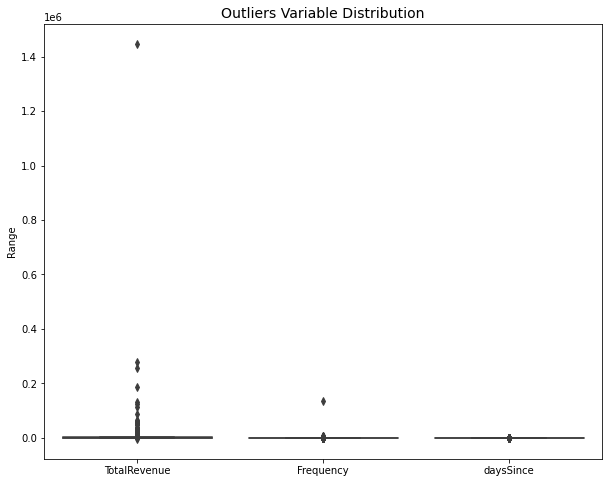

In [78]:
features = ['TotalRevenue', 'Frequency', 'daysSince']

plt.figure(figsize=(10,8))
sns.boxplot(data = df[features])
plt.title("Outliers Variable Distribution", fontsize = 14)
plt.ylabel("Range")

In [85]:
# remove statistical outliers (top 5%) for TotalRevenue
q1 = df.TotalRevenue.quantile(0.05)
q3 = df.TotalRevenue.quantile(0.95)
iqr = q3 - q1
df = df[(df.TotalRevenue >= q1 - 1.5*iqr) & (df.TotalRevenue <= q3 + 1.5*iqr)]

# remove statistical outliers (top 5%) for recency
q1 = df.daysSince.quantile(0.05)
q3 = df.daysSince.quantile(0.95)
iqr = q3 - q1
df = df[(df.daysSince >= q1 - 1.5*iqr) & (df.daysSince <= q3 + 1.5*iqr)]

# remove statistical outliers (top 5%) for frequency
q1 = df.Frequency.quantile(0.05)
q3 = df.Frequency.quantile(0.95)
iqr = q3 - q1
df = df[(df.Frequency >= q1 - 1.5*iqr) & (df.Frequency <= q3 + 1.5*iqr)]

Text(0, 0.5, 'Range')

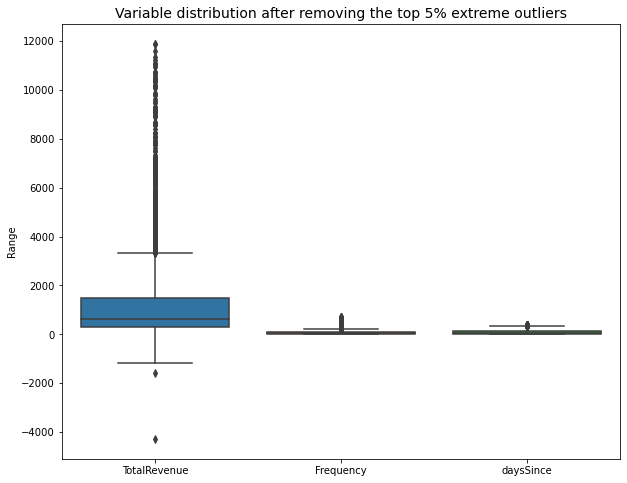

In [84]:
features = ['TotalRevenue', 'Frequency', 'daysSince']

plt.figure(figsize=(10,8))
sns.boxplot(data = df[features])
plt.title("Variable distribution after removing the top 5% extreme outliers", fontsize = 14)
plt.ylabel("Range")

### Rescale attributes

In [100]:
col_names = ['TotalRevenue', 'Frequency', 'daysSince']
features = df[col_names]

ct = ColumnTransformer(
        [('scaler', StandardScaler(), ['TotalRevenue', 'Frequency', 'daysSince'])], remainder='passthrough')
df_scaled = ct.fit_transform(features)

In [106]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['TotalRevenue', 'Frequency', 'daysSince']

In [108]:
df_scaled.head()

,TotalRevenue,Frequency,daysSince
0,-0.767368,-0.772646,2.294456
1,1.956501,1.122494,-0.910398
2,0.368466,-0.467318,-0.188317
3,0.343383,-0.025119,-0.742242
4,-0.556031,-0.614718,2.136192


## Model Training
### K-Means Clustering

In [110]:
# k-means with arbritrary k

kmeans = KMeans(n_clusters=5, max_iter=100)
kmeans.fit(df_scaled)

KMeans(max_iter=100, n_clusters=5)

In [112]:
kmeans.labels_

array([1, 0, 3, ..., 1, 3, 0])

#### Optimise number of clusters
We shall use the Elbow method to determine the optimal number of clusters, k.

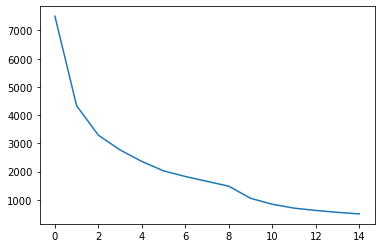

In [117]:
# elbow-curve / sum of squared differences (SSD)

ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40]

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n,
                    max_iter=100)
    kmeans.fit(df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot SSDs for each n_clusters
plt.plot(ssd)

#### Silhouette Analysis
- Silhouette Score ranges between -1 and 1. 
- A score close to 1 represents that the data point is simlar to other data points.
-  A score close to -1 represents that the data point is disimilar to other data points.

For n_clusters=2, the silhouette score is 0.5241513540247031
For n_clusters=3, the silhouette score is 0.5015312354249447
For n_clusters=4, the silhouette score is 0.4783712987781041
For n_clusters=5, the silhouette score is 0.4615648486381205
For n_clusters=6, the silhouette score is 0.4134280842200732
For n_clusters=7, the silhouette score is 0.40644217774257585
For n_clusters=8, the silhouette score is 0.38933699180622816
For n_clusters=9, the silhouette score is 0.37549193150047155
For n_clusters=10, the silhouette score is 0.37964463472791943
For n_clusters=15, the silhouette score is 0.32305035567618273
For n_clusters=20, the silhouette score is 0.3294389161461495
For n_clusters=25, the silhouette score is 0.3114655791947824
For n_clusters=30, the silhouette score is 0.31669179790961416
For n_clusters=35, the silhouette score is 0.28501348210183547
For n_clusters=40, the silhouette score is 0.30127837751239017


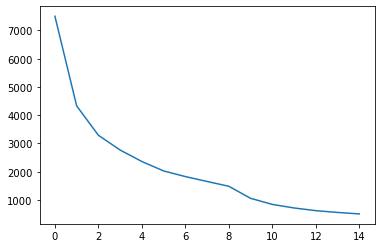

In [123]:
# silhouette analysis

range_n_clusters = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40]

sil_scores = []
for n in range_n_clusters:
    
    # initialise kmeans
    kmeans = KMeans(n_clusters=n, max_iter=100)
    kmeans.fit(df_scaled)
    
    cluster_labels = kmeans.labels_
    sil_scores.append(kmeans.inertia_)
    
    # silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))
    
# plot silhouette scores
plt.plot(sil_scores)

In [128]:
# Choose k=9
kmeans = KMeans(n_clusters=9, max_iter=100)
kmeans.fit(df_scaled)

KMeans(max_iter=100, n_clusters=9)

In [129]:
kmeans.labels_

array([2, 0, 1, ..., 4, 3, 1])

In [130]:
# assign the labels to the dataframe
df['ClusterID'] = kmeans.labels_
df.head()

,CustomerID,TotalRevenue,Frequency,daysSince,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


### Visualise K-Means clusters

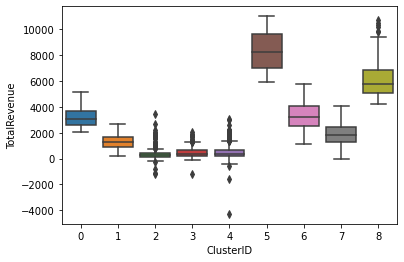

In [148]:
# boxplot to visualise clusters by TotalRevenue

sns.boxplot(data=df, x='ClusterID', y='TotalRevenue')

It seems that some customers are actually costing the business revenue. This is scope for investigation.

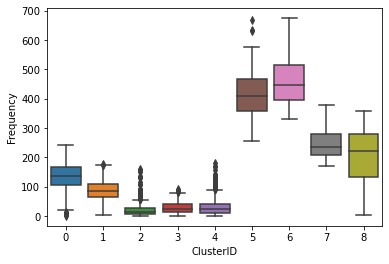

In [132]:
# boxplot to visualise clusters by Frequency

sns.boxplot(data=df, x='ClusterID', y='Frequency')

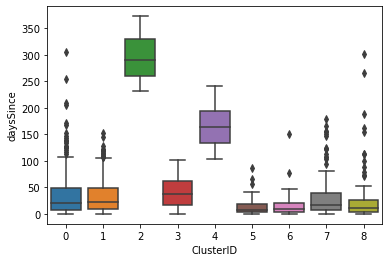

In [133]:
# boxplot to visualise clusters by Recency

sns.boxplot(data=df, x='ClusterID', y='daysSince')

### Hierarchical Clustering
Hierarchical clustering creates clusters that have a predetermined odering from top to bottom. 

#### Single Linkage
In single linkage hierarchical clustering, the distance between two clusers is defined as the shorted distance between two points in each cluster.

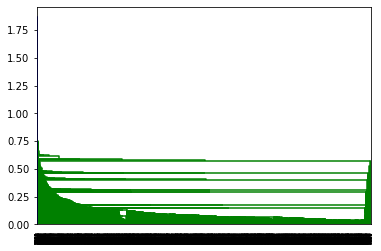

In [138]:
# single linkage
clustering = linkage(df_scaled, method='single', metric='euclidean')
dendrogram(clustering)
plt.show()

#### Complete Linkage
In complete linkage hierarchical clustering, the distance between two clusters is definated as the furthest distance between two points in each cluster.

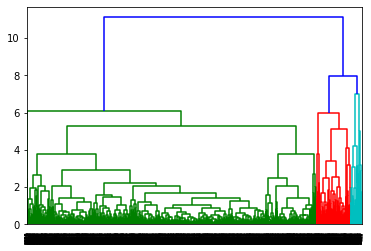

In [139]:
# complete linkage
clustering = linkage(df_scaled, method='complete', metric='euclidean')
dendrogram(clustering)
plt.show()

#### Average Linkage
In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to the other cluster.

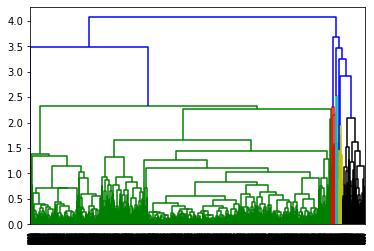

In [140]:
# average linkage
clustering = linkage(df_scaled, method='average', metric='euclidean')
dendrogram(clustering)
plt.show()

#### Cut Dendrogram by K

In [143]:
# 9 clusters
cluster_labels = cut_tree(clustering, n_clusters=9).reshape(-1, )
cluster_labels

array([0, 1, 2, ..., 0, 2, 2])

In [144]:
# assign cluster labels
df['h_ClusterID'] = cluster_labels
df.head()

,CustomerID,TotalRevenue,Frequency,daysSince,ClusterID,h_ClusterID
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,1,2
3,12349.0,1757.55,73,18,1,2
4,12350.0,334.40,17,309,2,0


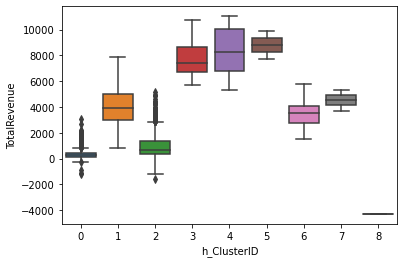

In [145]:
# boxplot to visualise clusters by TotalRevenue

sns.boxplot(data=df, x='h_ClusterID', y='TotalRevenue')

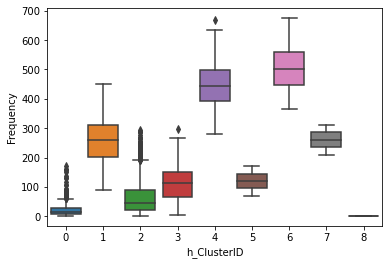

In [146]:
# boxplot to visualise clusters by Frequency

sns.boxplot(data=df, x='h_ClusterID', y='Frequency')

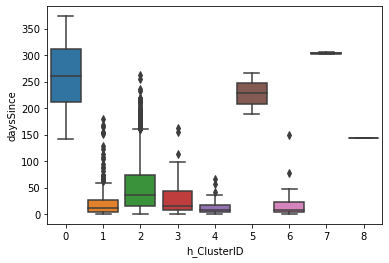

In [147]:
# boxplot to visualise clusters by Recency

sns.boxplot(data=df, x='h_ClusterID', y='daysSince')

### Insights from Clusters

K-Means clustering insights:
- Clusters 5 and 8 provide the highest total revenues
- Clusters 2, 3, and 4 provides the least amount of revenue and order the least frequently
- Clusters 6 and 5 order the most frequently
- Clusters 2 and 4 are the clusters that ordered most recently

Hierarchical clustering insights:
- Clusters 4, 5, and 3 provide the highest total revenue
- Clusters 6 and 4 are the customers who order most frequetly
- Clusters 0 and 7 are the customers who ordered most recently